In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    cm = confusion_matrix(y_test,pred)
    ac = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print('Confusion matrix : \n',cm)
    print("accuracy : {0:.4f}, precision : {1:.4f}, recall : {2:.4f}".format(ac,precision,recall))

In [2]:
#결측 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    return df


#불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df


#레이블 인코딩
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


#데이터 전처리 함수
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

titanic_df = pd.read_csv(r"C:\Users\suhye\Desktop\ADP\titanic_train.csv")
y = titanic_df['Survived']
X = titanic_df.drop('Survived',axis=1)
X = transform_features(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
get_clf_eval(y_test,pred)

Confusion matrix : 
 [[92 18]
 [16 53]]
accuracy : 0.8101, precision : 0.7465, recall : 0.7681


C:\Users\suhye\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 정밀도/재현율 트레이드오프

In [10]:
import numpy as np


proba = lr.predict_proba(X_test)
pred = lr.predict(X_test)
print("pred_proba() shape : {0}".format(pred.shape))
print(proba[:3])

#예측 확률 array와 예측 결과 array를 병합
result = np.concatenate([proba,pred.reshape(-1,1)],axis=1)
print("더 큰 확률을 클래스 값으로 예측 : \n",result[:3])

pred_proba() shape : (179,)
[[0.85141076 0.14858924]
 [0.89246256 0.10753744]
 [0.93366403 0.06633597]]
더 큰 확률을 클래스 값으로 예측 : 
 [[0.85141076 0.14858924 0.        ]
 [0.89246256 0.10753744 0.        ]
 [0.93366403 0.06633597 0.        ]]


threshold 값을 임의로 설정

In [11]:
from sklearn.preprocessing import Binarizer

X = [[1,-2,2],
    [2,0,0],
    [0,1.1,1.2]]

#X의 개별 원소들이 threshold보다 작거나 같으면 0, 크면 1반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [13]:
th = 0.5

pred_proba = proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = th).fit(pred_proba)
pred2 = binarizer.transform(pred_proba)

get_clf_eval(y_test,pred2)

Confusion matrix : 
 [[92 18]
 [16 53]]
accuracy : 0.8101, precision : 0.7465, recall : 0.7681


In [14]:
#threshold 설정값을 0.4로 변경
th = 0.4

pred_proba = proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = th).fit(pred_proba)
pred2 = binarizer.transform(pred_proba)

get_clf_eval(y_test,pred2)

Confusion matrix : 
 [[86 24]
 [13 56]]
accuracy : 0.7933, precision : 0.7000, recall : 0.8116


In [18]:
#모든 임계값을 리스트로 생성
thresholds = [0.4,0.45,0.5,0.55,0.6]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임계값 : ",custom_threshold)
        get_clf_eval(y_test,custom_predict)
        
        
get_eval_by_threshold(y_test,proba[:,1].reshape(-1,1),thresholds)

임계값 :  0.4
Confusion matrix : 
 [[86 24]
 [13 56]]
accuracy : 0.7933, precision : 0.7000, recall : 0.8116
임계값 :  0.45
Confusion matrix : 
 [[91 19]
 [14 55]]
accuracy : 0.8156, precision : 0.7432, recall : 0.7971
임계값 :  0.5
Confusion matrix : 
 [[92 18]
 [16 53]]
accuracy : 0.8101, precision : 0.7465, recall : 0.7681
임계값 :  0.55
Confusion matrix : 
 [[97 13]
 [18 51]]
accuracy : 0.8268, precision : 0.7969, recall : 0.7391
임계값 :  0.6
Confusion matrix : 
 [[99 11]
 [25 44]]
accuracy : 0.7989, precision : 0.8000, recall : 0.6377


In [20]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일때의 예측 확률 
pred_proba_class1 = lr.predict_proba(X_test)[:,1]

#실제 데이터셋과 레이블 값이 1일때의 예측 확률을 precision_recall_curve 인자로 입력
precisions,recalls,thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape : ',thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_index = np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개 :',thr_index)
print('샘플용 10개의 임계값 : ',np.round(thresholds[thr_index],2))

#15step 단위로 추출된 임계값에 따른 정밀도와 재현율
print("샘플 임계값 정밀도 : ",np.round(precisions[thr_index],3))
print("샘플 임계값 재현율  : ",np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 shape :  (166,)
샘플 추출을 위한 임계값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135 150 165]
샘플용 10개의 임계값 :  [0.06 0.1  0.11 0.15 0.19 0.28 0.43 0.57 0.65 0.8  0.91 0.97]
샘플 임계값 정밀도 :  [0.399 0.418 0.464 0.52  0.594 0.659 0.724 0.803 0.826 1.    1.    1.   ]
샘플 임계값 재현율  :  [1.    0.957 0.928 0.928 0.913 0.87  0.797 0.71  0.551 0.449 0.232 0.014]


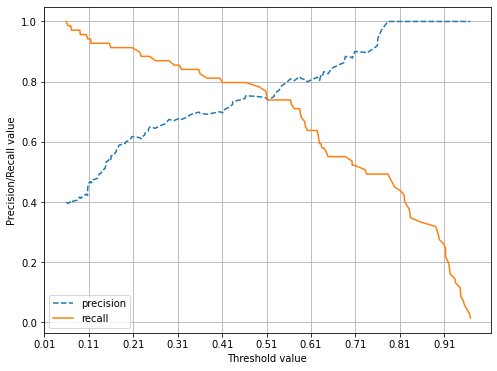

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test,pred_proba_c1):
    precisions,recalls,thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision/Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test,lr.predict_proba(X_test)[:,1])

## fl score

In [25]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print("F1 score : {0:.4f}".format(f1))

F1 score : 0.7571


In [26]:
def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print("confusion matrix : \n",confusion)
    print("accuracy : {0:.4f}, precision : {1:.4f}, recall : {2:.4f}, F1 : {3:.4f}".format(accuracy,precision,recall,f1))
    
thresholds = [0.4,0.45,0.5,0.55,0.6]
pred_proba = lr.predict_proba(X_test)
get_eval_by_threshold(y_test,proba[:,1].reshape(-1,1),thresholds)

임계값 :  0.4
confusion matrix : 
 [[86 24]
 [13 56]]
accuracy : 0.7933, precision : 0.7000, recall : 0.8116, F1 : 0.7517
임계값 :  0.45
confusion matrix : 
 [[91 19]
 [14 55]]
accuracy : 0.8156, precision : 0.7432, recall : 0.7971, F1 : 0.7692
임계값 :  0.5
confusion matrix : 
 [[92 18]
 [16 53]]
accuracy : 0.8101, precision : 0.7465, recall : 0.7681, F1 : 0.7571
임계값 :  0.55
confusion matrix : 
 [[97 13]
 [18 51]]
accuracy : 0.8268, precision : 0.7969, recall : 0.7391, F1 : 0.7669
임계값 :  0.6
confusion matrix : 
 [[99 11]
 [25 44]]
accuracy : 0.7989, precision : 0.8000, recall : 0.6377, F1 : 0.7097
